In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
from pathlib import Path
from typing import Literal

from matplotlib import pyplot as plt
from shapely.geometry import Point
from scipy.signal import find_peaks
import numpy as np

from s2shores.bathy_debug.spatial_correlation_bathy_estimator_debug import SpatialCorrelationBathyEstimatorDebug
from s2shores.waves_exceptions import WavesEstimationError, NotExploitableSinogram
from s2shores.image_processing.waves_radon import WavesRadon
from s2shores.generic_utils.image_utils import normalized_cross_correlation
from s2shores.generic_utils.signal_utils import find_period_from_zeros
from s2shores.bathy_physics import celerity_offshore, period_offshore, wavelength_offshore
from s2shores.bathy_debug.spatial_correlation_wave_fields_display import (
    build_sinograms_1D_analysis_spatial_correlation,
    build_sinograms_spatial_correlation,
    build_waves_images_spatial_correl,
)
from s2shores.bathy_debug.display_utils import get_display_title_with_kernel
from s2shores.bathy_debug.sinogram_display import (
    build_sinogram_display, 
    build_sinogram_difference_display,
    build_sinogram_1D_display_master,
    build_sinogram_1D_cross_correlation,
    build_sinogram_1D_display_slave,
    build_sinogram_2D_cross_correlation,
)
from s2shores.global_bathymetry.bathy_config import (
    BathyConfig,
    GlobalEstimatorConfig,
    SpatialCorrelationConfig,
)
from s2shores.bathy_debug.waves_image_display import (
    create_pseudorgb,
    build_display_waves_image,
    build_display_pseudorgb,
)

from utils import initialize_sequential_run, read_config

In [19]:
base_path = Path("../TestsS2Shores").resolve()
test_case: Literal["7_4", "8_2"] = "8_2"
method: Literal["spatial_corr", "spatial_dft", "temporal_corr"] = "spatial_corr"

product_path: Path = base_path / "products" / f"SWASH_{test_case}/testcase_{test_case}.tif"
config_path: Path = base_path / f"reference_results/debug_pointswash_{method}/wave_bathy_inversion_config.yaml"
debug_file: Path = base_path / f"debug_points/debug_points_SWASH_{test_case}.yaml"

estimation_point = Point(451.0, 499.0)

In [20]:
# config = read_config(config_path=config_path)

# OR

config = BathyConfig(
    GLOBAL_ESTIMATOR=GlobalEstimatorConfig(
        WAVE_EST_METHOD="SPATIAL_CORRELATION",
        MIN_D=2,
        MIN_T=3,
        MIN_WAVES_LINEARITY=0.01,
        SELECTED_FRAMES=[10, 13],
    )
)

If you want to change any parameter of the configuration, modify the values of the object `config` as you would with a dict.  

Example:
```python
config["parameter"] = "new_value"
```

In [21]:
bathy_estimator, ortho_bathy_estimator, ortho_sequence = initialize_sequential_run(
    product_path=product_path,
    point=estimation_point,
    config=config,
)

/home/geoffrey/miniconda3/envs/s2shores_env/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42209 instead
  warnings.warn(


In [22]:
local_estimator = SpatialCorrelationBathyEstimatorDebug(
    estimation_point,
    ortho_sequence,
    bathy_estimator,
)

if not local_estimator.can_estimate_bathy():
    raise WavesEstimationError("Cannot estimate bathy.")

## Preprocess images

Modified attributes:
- local_estimator.ortho_sequence.\<elements\>.pixels

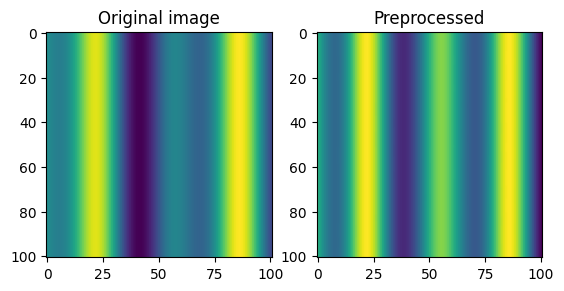

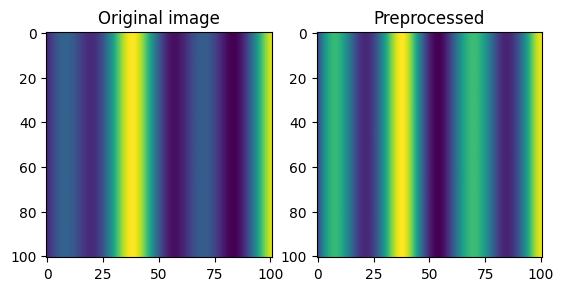

In [23]:
if False:
    local_estimator.preprocess_images()
else:
    for image in local_estimator.ortho_sequence:
        fig, axes = plt.subplots(1, 2)
        axes[0].imshow(image.pixels)
        axes[0].set_title("Original image")

        filtered_image = image.apply_filters(local_estimator.preprocessing_filters)
        image.pixels = filtered_image.pixels

        axes[1].imshow(image.pixels)
        axes[1].set_title("Preprocessed")


## Find direction

Modified attributes:
- None

New variables:
- estimated_direction

In [24]:
from s2shores.generic_utils.image_filters import circular_masking
from s2shores.generic_utils.symmetric_radon import symmetric_radon
from s2shores.image_processing.waves_radon import linear_directions
from s2shores.image_processing.waves_sinogram import WavesSinogram


if False:
    estimated_direction = local_estimator.find_direction()
else:

    # Start: WavesRadon(self.ortho_sequence[0], self.selected_directions)
    image = local_estimator.ortho_sequence[0]
    sampling_frequency = 1. / image.resolution
    selected_directions = local_estimator.selected_directions

    pixels = circular_masking(image.pixels.copy())
    radon_transform = symmetric_radon(image=pixels, theta=selected_directions)

    waves_radon = {
        direction: WavesSinogram(radon_transform[:, idx])
        for idx, direction in enumerate(selected_directions)
    }
    # End: WavesRadon


    # Start: WavesRadon.get_direction_maximum_variance()

    # Start: Sinograms.get_sinograms_variances(selected_directions)
    variances = np.empty(len(selected_directions), dtype=np.float64)
    for result_index, direction in enumerate(selected_directions):
        variances[result_index] = waves_radon[direction].variance
    # End: Sinograms.get_sinograms_variances

    index_max_variance = np.argmax(variances)
    estimated_direction = selected_directions[index_max_variance]
    # End: WavesRadon.get_direction_maximum_variance

estimated_direction

-180.0

**TODO**: plot sinogram avec le max de variance (display_sinograms_debug_point 2eme row 1ere column)

## Compute radon transforms

New elements:
- local_estimator.randon_transforms

In [25]:
DEFAULT_QUANTIZATION_STEP = 0.1

if False:
    local_estimator.compute_radon_transforms(estimated_direction)
else:
    for image in local_estimator.ortho_sequence:
        radon_transform = WavesRadon(image, np.array([estimated_direction]))
        # Start: WavesRadon(image, np.array([estimated_direction]))
        sampling_frequency = 1. / image.resolution
        selected_directions = np.array([estimated_direction])

        pixels = circular_masking(image.pixels.copy())
        radon_transform = symmetric_radon(image=pixels, theta=selected_directions)

        waves_radon = {
            direction: WavesSinogram(radon_transform[:, idx])
            for idx, direction in enumerate(selected_directions)
        }
        # End: WavesRadon
        
        # Start: Sinograms.radon_augmentation(self.radon_augmentation_factor)
        radon_augmented = {
            direction: waves_radon[direction].interpolate(local_estimator.radon_augmentation_factor)
            for direction in selected_directions
        }
        sampling_frequency = sampling_frequency / local_estimator.radon_augmentation_factor
        quantization_step = DEFAULT_QUANTIZATION_STEP
        # End: Sinograms.radon_augmentation(self.radon_augmentation_factor)

        local_estimator.radon_transforms.append(radon_augmented)

## Compute spatial correlation

New elements:
- local_estimator.sinograms

New variables:
- correlation_signal

In [26]:
if False:
    correlation_signal = local_estimator.compute_spatial_correlation(estimated_direction)
else:
    for radon_transform in local_estimator.radon_transforms:
        tmp_wavessinogram = radon_transform[estimated_direction]
        tmp_wavessinogram.values *= tmp_wavessinogram.variance
        local_estimator.sinograms.append(tmp_wavessinogram)
    sinogram_1 = local_estimator.sinograms[0].values
    # TODO: should be independent from 0/1 (for multiple pairs of frames)
    sinogram_2 = local_estimator.sinograms[1].values
    correl_mode = local_estimator.local_estimator_params['CORRELATION_MODE']
    corr_init = normalized_cross_correlation(sinogram_1, sinogram_2, correl_mode)
    corr_init_ac = normalized_cross_correlation(corr_init, corr_init, correl_mode)
    corr_1 = normalized_cross_correlation(corr_init_ac, sinogram_1, correl_mode)
    corr_2 = normalized_cross_correlation(corr_init_ac, sinogram_2, correl_mode)
    correlation_signal = normalized_cross_correlation(corr_1, corr_2, correl_mode)

correlation_signal

array([0.35087632, 0.35155629, 0.35223523, ..., 0.4365695 , 0.43612603,
       0.43568104])

## Compute wavelength

Modified attributes:
- None

New variables:
- wavelength

In [27]:
if False:
    wavelength = local_estimator.compute_wavelength(correlation_signal)
else:
    min_wavelength = wavelength_offshore(
        local_estimator.global_estimator.waves_period_min,
        local_estimator.gravity,
    )
    min_period_unitless = int(min_wavelength / local_estimator.augmented_resolution)
    try:
        period, _ = find_period_from_zeros(correlation_signal, min_period_unitless)
        wavelength = period * local_estimator.augmented_resolution
    except ValueError as excp:
        raise NotExploitableSinogram('Wave length can not be computed from sinogram') from excp
    
wavelength

63.20542135459565

## Compute delta position

Modified attributes:
- None

New variables:
- delta_position

In [28]:
if False:
    delta_position = local_estimator.compute_delta_position(correlation_signal, wavelength)
else:
    peaks_pos, _ = find_peaks(correlation_signal)
    if peaks_pos.size == 0:
        raise WavesEstimationError('Unable to find any directional peak')
    argmax_ac = len(correlation_signal) // 2
    relative_distance = (peaks_pos - argmax_ac) * local_estimator.augmented_resolution

    celerity_offshore_max = celerity_offshore(
        local_estimator.global_estimator.waves_period_max,
        local_estimator.gravity,
    )
    spatial_shift_offshore_max = celerity_offshore_max * local_estimator.propagation_duration
    spatial_shift_min = min(-spatial_shift_offshore_max, spatial_shift_offshore_max)
    spatial_shift_max = -spatial_shift_min

    stroboscopic_factor_offshore = local_estimator.propagation_duration / period_offshore(
        1 / wavelength, local_estimator.gravity)
    
    if abs(stroboscopic_factor_offshore) >= 1:
        # unused for s2
        print('test stroboscopie vrai')
        spatial_shift_offshore_max = (
            local_estimator.local_estimator_params['PEAK_POSITION_MAX_FACTOR']
            * stroboscopic_factor_offshore
            * wavelength
        )

    pt_in_range = peaks_pos[np.where(
        (relative_distance >= spatial_shift_min)
        & (relative_distance < spatial_shift_max)
    )]
    if pt_in_range.size == 0:
        raise WavesEstimationError('Unable to find any directional peak')
    argmax = pt_in_range[correlation_signal[pt_in_range].argmax()]
    delta_position = (argmax - argmax_ac) * local_estimator.augmented_resolution

delta_position

-29.36

## Save wave field estimation

New elements:
- local_estimator.bathymetry_estimations

In [29]:
if False:
    local_estimator.save_wave_field_estimation(estimated_direction, wavelength, delta_position)
else:
    bathymetry_estimation = local_estimator.create_bathymetry_estimation(estimated_direction, wavelength)
    bathymetry_estimation.delta_position = delta_position
    local_estimator.bathymetry_estimations.append(bathymetry_estimation)

bathymetry_estimation.is_physical()

True

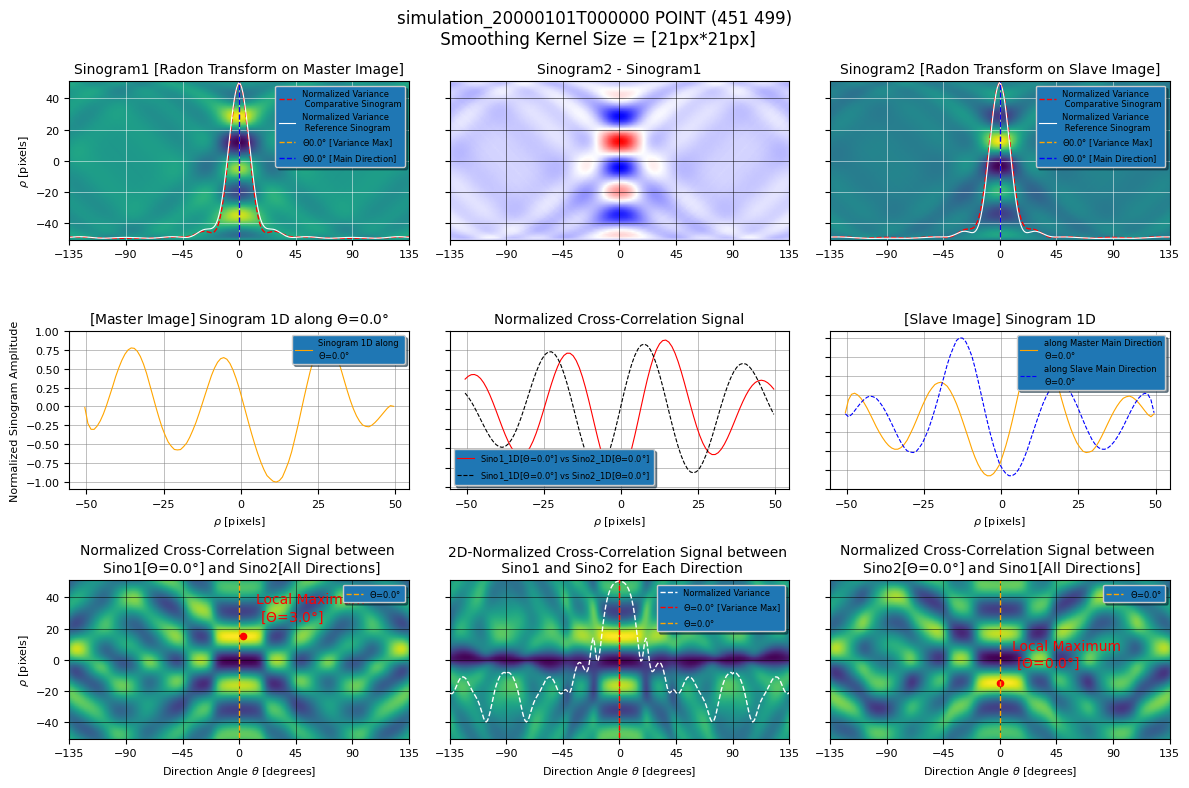

In [30]:
if False:
    build_sinograms_1D_analysis_spatial_correlation(local_estimator)
else:
    local_estimator = local_estimator

    # plt.close('all')
    nrows = 3
    ncols = 3
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8))
    fig.suptitle(get_display_title_with_kernel(local_estimator), fontsize=12)

    first_image = local_estimator.ortho_sequence[0]
    second_image = local_estimator.ortho_sequence[1]

    # First Plot line = Sinogram1 / Sinogram2-Sinogram1 / Sinogram2
    first_radon_transform = WavesRadon(first_image)
    sinogram1, directions1 = first_radon_transform.get_as_arrays()
    second_radon_transform = WavesRadon(second_image)
    sinogram2, directions2 = second_radon_transform.get_as_arrays()
    radon_difference = (sinogram2 / np.max(np.abs(sinogram2))) - \
        (sinogram1 / np.max(np.abs(sinogram1)))
    # get main direction
    main_direction = local_estimator.bathymetry_estimations.get_estimations_attribute('direction')[
        0]

    plt_min = local_estimator.global_estimator.local_estimator_params['DEBUG']['PLOT_MIN']
    plt_max = local_estimator.global_estimator.local_estimator_params['DEBUG']['PLOT_MAX']

    build_sinogram_display(
        axs[0, 0], 'Sinogram1 [Radon Transform on Master Image]',
        sinogram1, directions1, sinogram2, main_direction, plt_min, plt_max, abscissa=False)
    build_sinogram_difference_display(
        axs[0, 1], 'Sinogram2 - Sinogram1', radon_difference, directions2, plt_min, plt_max,
        abscissa=False, cmap='bwr')
    build_sinogram_display(
        axs[0, 2], 'Sinogram2 [Radon Transform on Slave Image]', sinogram2, directions2, sinogram1,
        main_direction, plt_min, plt_max, ordonate=False, abscissa=False)

    # Second Plot line = SINO_1 [1D along estimated direction] / Cross-Correlation Signal /
    # SINO_2 [1D along estimated direction resulting from Image1]
    # Check if the main direction belongs to the plotting interval [plt_min:plt_max]
    if main_direction < plt_min or main_direction > plt_max:
        theta_label = main_direction % (-np.sign(main_direction) * 180.0)
    else:
        theta_label = main_direction
    title_sino1 = '[Master Image] Sinogram 1D along $\\Theta$={:.1f}° '.format(theta_label)
    title_sino2 = '[Slave Image] Sinogram 1D'.format(theta_label)
    correl_mode = local_estimator.global_estimator.local_estimator_params['CORRELATION_MODE']

    build_sinogram_1D_display_master(
        axs[1, 0], title_sino1, sinogram1, directions1, main_direction, plt_min, plt_max)
    build_sinogram_1D_cross_correlation(
        axs[1, 1], 'Normalized Cross-Correlation Signal', sinogram1, directions1, main_direction,
        sinogram2, directions2, plt_min, plt_max, correl_mode, ordonate=False)
    build_sinogram_1D_display_slave(
        axs[1, 2], title_sino2,
        sinogram2, directions2, main_direction, plt_min, plt_max, ordonate=False)

    # Third Plot line = Image [2D] Cross correl Sino1[main dir] with Sino2 all directions /
    # Image [2D] of Cross correlation 1D between SINO1 & SINO 2 for each direction /
    # Image [2D] Cross correl Sino2[main dir] with Sino1 all directions
    # Check if the main direction belongs to the plotting interval [plt_min:plt_ramax]

    title_cross_correl1 = 'Normalized Cross-Correlation Signal between \n Sino1[$\\Theta$={:.1f}°] and Sino2[All Directions]'.format(
        theta_label)
    title_cross_correl2 = 'Normalized Cross-Correlation Signal between \n Sino2[$\\Theta$={:.1f}°] and Sino1[All Directions]'.format(
        0)
    title_cross_correl_2D = '2D-Normalized Cross-Correlation Signal between \n Sino1 and Sino2 for Each Direction'

    build_sinogram_2D_cross_correlation(
        axs[2, 0], title_cross_correl1, sinogram1, directions1, main_direction,
        sinogram2, plt_min, plt_max, correl_mode, choice='one_dir', imgtype='master')
    build_sinogram_2D_cross_correlation(
        axs[2, 1], title_cross_correl_2D, sinogram1, directions1, main_direction,
        sinogram2, plt_min, plt_max, correl_mode, choice='all_dir', imgtype='master', ordonate=False)
    build_sinogram_2D_cross_correlation(
        axs[2, 2], title_cross_correl2, sinogram2, directions2, main_direction,
        sinogram1, plt_min, plt_max, correl_mode, choice='one_dir', imgtype='slave', ordonate=False)

    plt.tight_layout()

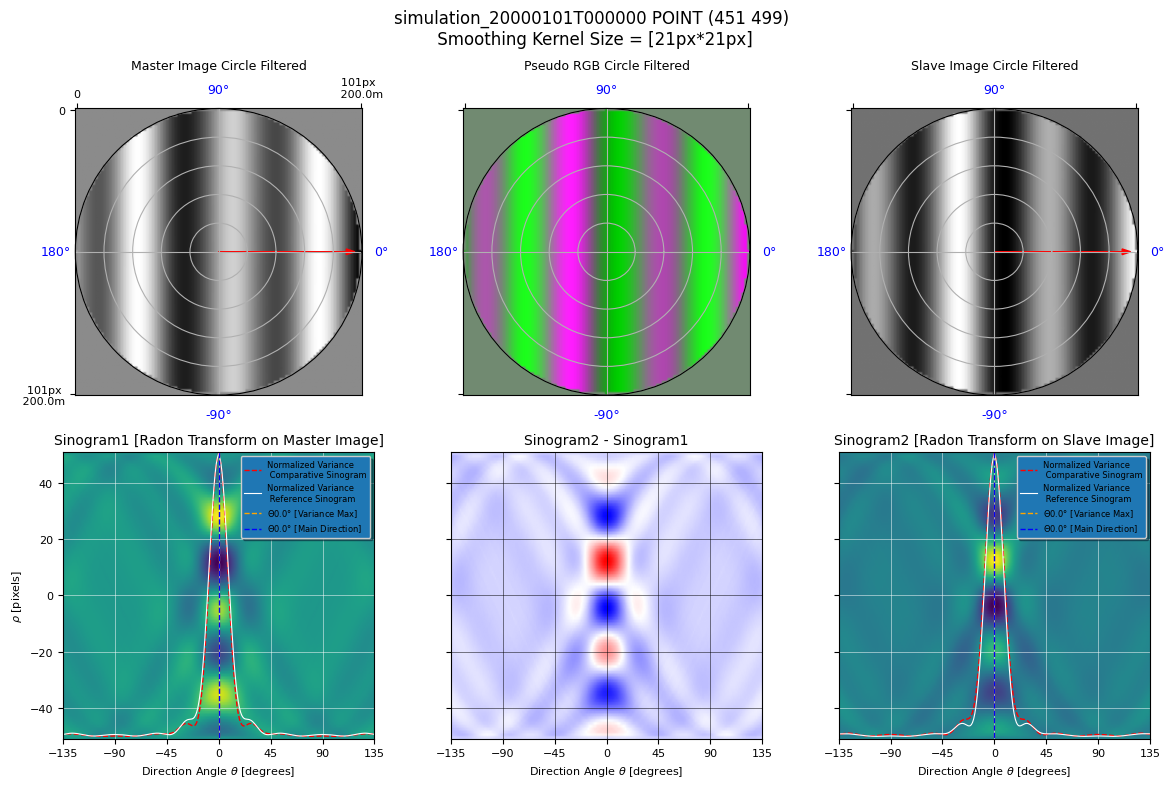

In [31]:
if False:
    build_sinograms_spatial_correlation(local_estimator)
else:
    nrows = 2
    ncols = 3
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8))
    fig.suptitle(get_display_title_with_kernel(local_estimator), fontsize=12)
    first_image = local_estimator.ortho_sequence[0]
    second_image = local_estimator.ortho_sequence[1]

    # Since wfe.energy_ratio not available for SpatialCorrelation:
    default_arrow_length = np.shape(first_image.original_pixels)[0]
    arrows = [(wfe.direction, default_arrow_length)
              for wfe in local_estimator.bathymetry_estimations]

    # First Plot line = Image1 Circle Filtered / pseudoRGB Circle Filtered/ Image2 Circle Filtered
    image1_circle_filtered = first_image.pixels * first_image.circle_image
    image2_circle_filtered = second_image.pixels * second_image.circle_image
    pseudo_rgb_circle_filtered = create_pseudorgb(image1_circle_filtered, image2_circle_filtered)
    build_display_waves_image(fig, axs[0, 0], 'Master Image Circle Filtered',
                              image1_circle_filtered, subplot_pos=[nrows, ncols, 1],
                              resolution=first_image.resolution, directions=arrows, cmap='gray')
    build_display_pseudorgb(fig,
                            axs[0,
                                1],
                            'Pseudo RGB Circle Filtered',
                            pseudo_rgb_circle_filtered,
                            resolution=first_image.resolution,
                            subplot_pos=[nrows,
                                         ncols,
                                         2],
                            coordinates=False)
    build_display_waves_image(fig,
                              axs[0,
                                  2],
                              'Slave Image Circle Filtered',
                              image2_circle_filtered,
                              resolution=second_image.resolution,
                              subplot_pos=[nrows,
                                           ncols,
                                           3],
                              directions=arrows,
                              cmap='gray',
                              coordinates=False)

    # Second Plot line = Sinogram1 / Sinogram2-Sinogram1 / Sinogram2
    first_radon_transform = WavesRadon(first_image)
    sinogram1, directions1 = first_radon_transform.get_as_arrays()
    second_radon_transform = WavesRadon(second_image)
    sinogram2, directions2 = second_radon_transform.get_as_arrays()
    radon_difference = (sinogram2 / np.max(np.abs(sinogram2))) - \
        (sinogram1 / np.max(np.abs(sinogram1)))
    # get main direction
    main_direction = local_estimator.bathymetry_estimations.get_estimations_attribute('direction')[
        0]

    plt_min = local_estimator.global_estimator.local_estimator_params['DEBUG']['PLOT_MIN']
    plt_max = local_estimator.global_estimator.local_estimator_params['DEBUG']['PLOT_MAX']

    build_sinogram_display(
        axs[1, 0], 'Sinogram1 [Radon Transform on Master Image]', sinogram1, directions1, sinogram2,
        main_direction, plt_min, plt_max)
    build_sinogram_difference_display(
        axs[1, 1], 'Sinogram2 - Sinogram1', radon_difference, directions2, plt_min, plt_max, cmap='bwr')
    build_sinogram_display(
        axs[1, 2], 'Sinogram2 [Radon Transform on Slave Image]', sinogram2, directions2, sinogram1,
        main_direction, plt_min, plt_max, ordonate=False)

    plt.tight_layout()

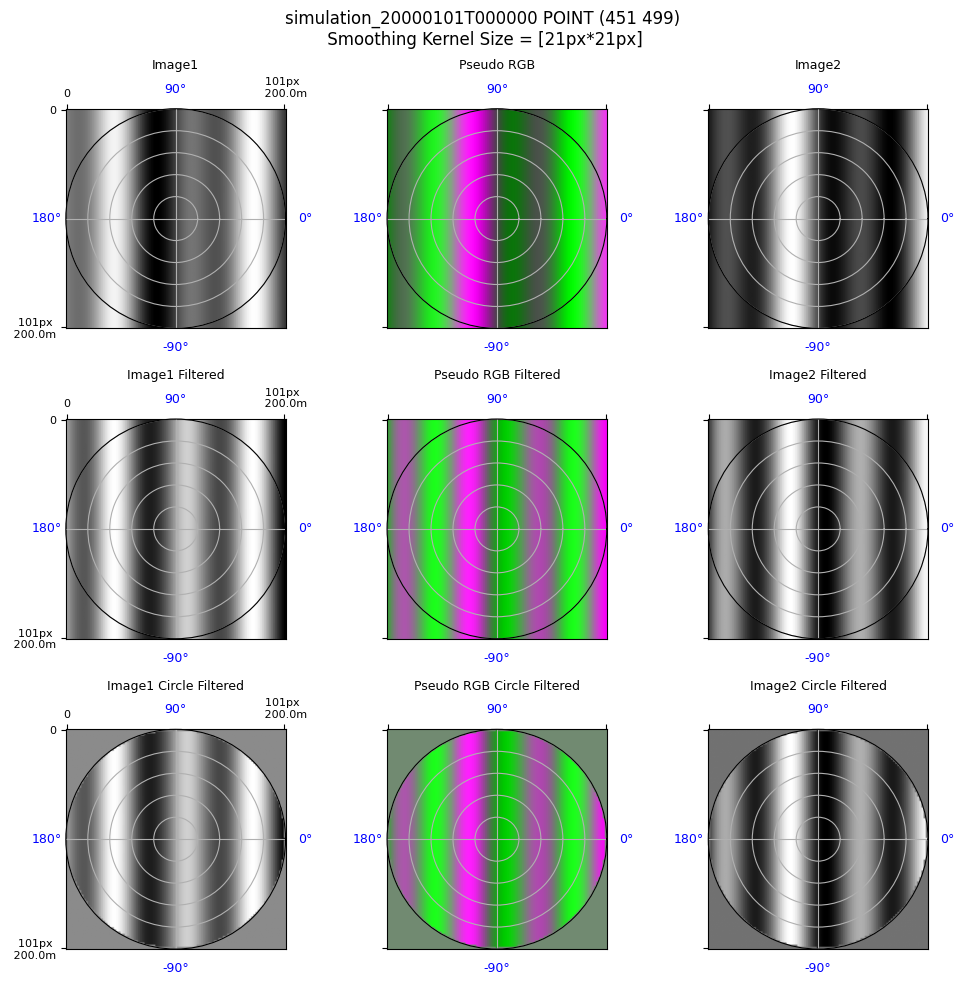

In [32]:
if False:
    build_waves_images_spatial_correl(local_estimator)
else:
    nrows = 3
    ncols = 3
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))
    fig.suptitle(get_display_title_with_kernel(local_estimator), fontsize=12)

    first_image = local_estimator.ortho_sequence[0]
    second_image = local_estimator.ortho_sequence[1]
    pseudo_rgb = create_pseudorgb(first_image.original_pixels, second_image.original_pixels)

    # First Plot line = Image1 / pseudoRGB / Image2
    build_display_waves_image(fig, axs[0, 0], 'Image1', first_image.original_pixels,
                              resolution=first_image.resolution,
                              subplot_pos=[nrows, ncols, 1], cmap='gray')
    build_display_pseudorgb(fig, axs[0, 1], 'Pseudo RGB', pseudo_rgb,
                            resolution=first_image.resolution,
                            subplot_pos=[nrows, ncols, 2], coordinates=False)
    build_display_waves_image(fig, axs[0, 2], 'Image2', second_image.original_pixels,
                              resolution=second_image.resolution,
                              subplot_pos=[nrows, ncols, 3], cmap='gray', coordinates=False)

    # Second Plot line = Image1 Filtered / pseudoRGB Filtered/ Image2 Filtered
    pseudo_rgb_filtered = create_pseudorgb(first_image.pixels, second_image.pixels)
    build_display_waves_image(fig, axs[1, 0], 'Image1 Filtered', first_image.pixels,
                              resolution=first_image.resolution,
                              subplot_pos=[nrows, ncols, 4], cmap='gray')
    build_display_pseudorgb(fig, axs[1, 1], 'Pseudo RGB Filtered', pseudo_rgb_filtered,
                            resolution=first_image.resolution,
                            subplot_pos=[nrows, ncols, 5], coordinates=False)
    build_display_waves_image(fig, axs[1, 2], 'Image2 Filtered', second_image.pixels,
                              resolution=second_image.resolution,
                              subplot_pos=[nrows, ncols, 6], cmap='gray', coordinates=False)

    # Third Plot line = Image1 Circle Filtered / pseudoRGB Circle Filtered/ Image2 Circle Filtered
    image1_circle_filtered = first_image.pixels * first_image.circle_image
    image2_circle_filtered = second_image.pixels * second_image.circle_image
    pseudo_rgb_circle_filtered = create_pseudorgb(image1_circle_filtered, image2_circle_filtered)
    build_display_waves_image(fig, axs[2, 0], 'Image1 Circle Filtered', image1_circle_filtered,
                              resolution=first_image.resolution,
                              subplot_pos=[nrows, ncols, 7], cmap='gray')
    build_display_pseudorgb(fig,
                            axs[2,
                                1],
                            'Pseudo RGB Circle Filtered',
                            pseudo_rgb_circle_filtered,
                            resolution=first_image.resolution,
                            subplot_pos=[nrows,
                                         ncols,
                                         8],
                            coordinates=False)
    build_display_waves_image(fig, axs[2, 2], 'Image2 Circle Filtered', image2_circle_filtered,
                              resolution=second_image.resolution,
                              subplot_pos=[nrows, ncols, 9], cmap='gray', coordinates=False)
    plt.tight_layout()

## TODO

- Créer une fonction pour les premières étapes ✅
- Documenter les modifications des attributs d'instance de chaque méthode du run ✅
- Eclater la cellule de run ✅
- rentrer dans chaque étape ✅
- flag _DEFAULT pour chaque étape ou custom function ✅
- faire la même chose pour les 3 méthodes
- vérifier la VT ✅
- vérifier l'exécution sur JupyterHub ✅


Option: Configuration pydantic ✅